In [1]:
# libraries
import os
import subprocess
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import ripple_detection
from ripple_detection import filter_ripple_band
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import windows
from scipy.ndimage import convolve
from scipy import stats
from tqdm import tqdm
from allensdk.brain_observatory.behavior.behavior_project_cache import (
    VisualBehaviorNeuropixelsProjectCache,
)
from scipy import interpolate
from scipy.signal import firwin, lfilter
from fitter import Fitter, get_common_distributions, get_distributions
import time
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import zscore
from scipy.ndimage.filters import gaussian_filter
import glob
import pickle

/tmp/ipykernel_16208/733713011.py:25: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
gamma_filter_path = "/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/frank2008_gamma_1500hz_bandpass_filter.npz"
# The path to the theta filter
theta_filter_path = "/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/theta_1500hz_bandpass_filter.npz"
# The ripple band threshold

# loading filters (craetes artifacts in first and last ~ 3.5 seconds of recordings, remember to clip these off)
gamma_filter = np.load(gamma_filter_path)
gamma_filter = gamma_filter["arr_0"]

theta_filter = np.load(theta_filter_path)
theta_filter = theta_filter["arr_0"]
sdk_cache_dir = "/space/scratch/allen_visbehave_data"
# Setting up the ABI Cache (where data is held, what is present or absent)
manifest_path = os.path.join(sdk_cache_dir, "manifest.json")

cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=sdk_cache_dir)

# we start by calling and filtering our dataframe of the sessions we will be working with
sessions = cache.get_ecephys_session_table()

## Mouse info

In [3]:
abi_visbehave_ripples_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_murphylab2024"
)

# Assuming cache.get_ecephys_session_table() has been called to populate 'sessions'
sessions = cache.get_ecephys_session_table()

unique_mouse_ids = set()

for sessionfolder in os.listdir(abi_visbehave_ripples_path):
    if ".csv" in sessionfolder:
        continue

    session_id = sessionfolder.split("_")[-1]
    if int(session_id) in sessions.index:
        mouse_id = sessions.loc[int(session_id), "mouse_id"]
        unique_mouse_ids.add(mouse_id)

# Filter the sessions DataFrame for these unique mouse IDs
filtered_sessions = sessions[sessions["mouse_id"].isin(unique_mouse_ids)]

# Now group by 'mouse_id' to get mouse_info for later use
mouse_info = filtered_sessions.groupby("mouse_id")

from math import floor

# Example usage: print genotype, strain, age, and sex for each mouse
for mouse_id, group in mouse_info:
    # print(f"Mouse ID: {mouse_id}")
    print(f"Genotype: {group['genotype'].iloc[0]}")
    print(f"Age (Weeks): {floor(group['age_in_days'].iloc[0]/7)}")
    print(f"Sex: {group['sex'].iloc[0]}\n")

Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 37
Sex: M

Genotype: Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 27
Sex: F

Genotype: wt/wt
Age (Weeks): 25
Sex: F

Genotype: wt/wt
Age (Weeks): 21
Sex: F

Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 23
Sex: F

Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 25
Sex: M

Genotype: Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 21
Sex: M

Genotype: Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 20
Sex: M

Genotype: wt/wt
Age (Weeks): 20
Sex: M

Genotype: wt/wt
Age (Weeks): 20
Sex: F

Genotype: Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 24
Sex: M

Genotype: wt/wt
Age (Weeks): 19
Sex: M

Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 17
Sex: F

Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 17
Sex: M

Genotype: wt/wt
Age (Weeks): 18
Sex: M

Genotype: wt/wt
Age (Weeks): 17
Sex: M



In [4]:
from math import floor

# Example usage: print genotype, strain, age, and sex for each mouse
for mouse_id, group in mouse_info:
    # print(f"Mouse ID: {mouse_id}")
    print(f"Genotype: {group['genotype'].iloc[0]}")
    print(f"Age (Weeks): {floor(group['age_in_days'].iloc[0]/7)}")
    print(f"Sex: {group['sex'].iloc[0]}\n")

Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 37
Sex: M

Genotype: Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 27
Sex: F

Genotype: wt/wt
Age (Weeks): 25
Sex: F

Genotype: wt/wt
Age (Weeks): 21
Sex: F

Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 23
Sex: F

Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 25
Sex: M

Genotype: Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 21
Sex: M

Genotype: Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 20
Sex: M

Genotype: wt/wt
Age (Weeks): 20
Sex: M

Genotype: wt/wt
Age (Weeks): 20
Sex: F

Genotype: Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 24
Sex: M

Genotype: wt/wt
Age (Weeks): 19
Sex: M

Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 17
Sex: F

Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 17
Sex: M

Genotype: wt/wt
Age (Weeks): 18
Sex: M

Genotype: wt/wt
Age (Weeks): 17
Sex: M



In [5]:
import os
from math import floor

abi_visbehave_ripples_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_murphylab2024"
)

# Assuming cache.get_ecephys_session_table() has been called to populate 'sessions'
sessions = cache.get_ecephys_session_table()

unique_mouse_ids = set()
karlsson_files_count = (
    {}
)  # Dictionary to store lists of 'karlsson' file counts per mouse

for sessionfolder in os.listdir(abi_visbehave_ripples_path):
    if ".csv" in sessionfolder:
        continue

    session_id = sessionfolder.split("_")[-1]
    if int(session_id) in sessions.index:
        mouse_id = sessions.loc[int(session_id), "mouse_id"]
        unique_mouse_ids.add(mouse_id)

        # Count 'karlsson' files in the session folder
        count = sum(
            "karlsson" in filename
            for filename in os.listdir(
                os.path.join(abi_visbehave_ripples_path, sessionfolder)
            )
        )
        if mouse_id not in karlsson_files_count:
            karlsson_files_count[mouse_id] = []
        karlsson_files_count[mouse_id].append(count)

# Filter the sessions DataFrame for these unique mouse IDs
filtered_sessions = sessions[sessions["mouse_id"].isin(unique_mouse_ids)]

# Now group by 'mouse_id' to get mouse_info for later use
mouse_info = filtered_sessions.groupby("mouse_id")

# Example usage: print genotype, strain, age, sex, and average 'karlsson' file count for each mouse
for mouse_id, group in mouse_info:
    print(f"Genotype: {group['genotype'].iloc[0]}")
    print(f"Age (Weeks): {floor(group['age_in_days'].iloc[0]/7)}")
    print(f"Sex: {group['sex'].iloc[0]}")
    # Calculate and print the average 'karlsson' file count for the mouse
    avg_karlsson_files = (
        sum(karlsson_files_count[mouse_id]) / len(karlsson_files_count[mouse_id])
        if mouse_id in karlsson_files_count
        else 0
    )
    print(f"Probes in CA1 count: {avg_karlsson_files}\n")

Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 37
Sex: M
Probes in CA1 count: 4.5

Genotype: Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 27
Sex: F
Probes in CA1 count: 2.0

Genotype: wt/wt
Age (Weeks): 25
Sex: F
Probes in CA1 count: 5.0

Genotype: wt/wt
Age (Weeks): 21
Sex: F
Probes in CA1 count: 4.0

Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 23
Sex: F
Probes in CA1 count: 1.0

Genotype: Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 25
Sex: M
Probes in CA1 count: 5.0

Genotype: Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 21
Sex: M
Probes in CA1 count: 4.0

Genotype: Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 20
Sex: M
Probes in CA1 count: 3.0

Genotype: wt/wt
Age (Weeks): 20
Sex: M
Probes in CA1 count: 5.0

Genotype: wt/wt
Age (Weeks): 20
Sex: F
Probes in CA1 count: 3.5

Genotype: Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt
Age (Weeks): 24
Sex: M
Probes in CA1 count: 5.0

Genot

## Number of ripples by thresholds

In [6]:
abi_ripples_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_murphylab2024"
)
abi_lfp_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_murphylab2024_lfp_data"
)
theta_filter_path = "/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/theta_1500hz_bandpass_filter.npz"
theta_filter = np.load(theta_filter_path)
theta_filter = theta_filter["arr_0"]

In [7]:
karlsson_count = 0  # Initialize counter

for sessionfolder in os.listdir(abi_ripples_path):
    # Skip session folders that end with '.csv'
    if sessionfolder.endswith(".csv"):
        continue

    session_path = os.path.join(abi_ripples_path, sessionfolder)

    # Iterate through files in the session folder
    for file in os.listdir(session_path):
        file_path = os.path.join(session_path, file)

        # Check if it's a file and 'karlsson' is in the filename
        if os.path.isfile(file_path) and "karlsson" in file:
            karlsson_count += 1  # Increment counter

# Print the total count of files with 'karlsson' in their name
print('Total number of files with "karlsson" in the name:', karlsson_count)

Total number of files with "karlsson" in the name: 408


In [8]:
sessions.session_number

ecephys_session_id
1044385384    1
1044594870    2
1047969464    1
1047977240    1
1048189115    2
             ..
1130349290    2
1139846596    1
1140102579    2
1152632711    1
1152811536    2
Name: session_number, Length: 103, dtype: int64

In [9]:
sessions = cache.get_ecephys_session_table()
print(sessions.columns)
sessions

Index(['behavior_session_id', 'date_of_acquisition', 'equipment_name',
       'session_type', 'mouse_id', 'genotype', 'sex', 'project_code',
       'age_in_days', 'unit_count', 'probe_count', 'channel_count',
       'structure_acronyms', 'image_set', 'prior_exposures_to_image_set',
       'session_number', 'experience_level', 'prior_exposures_to_omissions',
       'file_id', 'abnormal_histology', 'abnormal_activity'],
      dtype='object')


,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,...,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1044385384,1044408432,2020-08-19 14:47:08.574000+00:00,NP.1,EPHYS_1_images_G_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,151,2179.0,...,1920.0,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'LGv...",G,30,1,Familiar,0,870,NaN,NaN
1044594870,1044624428,2020-08-20 15:03:56.422000+00:00,NP.1,EPHYS_1_images_H_5uL_reward,524761,wt/wt,F,NeuropixelVisualBehavior,152,2103.0,...,1920.0,"['CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg', 'HPF...",H,0,2,Novel,1,872,NaN,NaN
1047969464,1048005547,2020-09-02 14:53:14.347000+00:00,NP.1,EPHYS_1_images_G_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,263,2438.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,62,1,Familiar,0,877,NaN,NaN
1047977240,1048009327,2020-09-02 15:15:03.733000+00:00,NP.0,EPHYS_1_images_G_3uL_reward,524925,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,165,1856.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,51,1,Familiar,0,878,NaN,NaN
1048189115,1048221709,2020-09-03 14:16:57.913000+00:00,NP.1,EPHYS_1_images_H_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,264,1925.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0,2,Novel,1,879,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130349290,1130378962,2021-09-23 13:34:57.267000+00:00,NP.0,EPHYS_1_images_G_3uL_reward,579993,wt/wt,F,NeuropixelVisualBehavior,165,1928.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-sg', 'HPF',...",G,0,2,Novel,1,1017,NaN,NaN
1139846596,1139969640,2021-11-10 15:08:35.544000+00:00,NP.1,EPHYS_1_images_H_3uL_reward,585329,wt/wt,M,NeuropixelVisualBehavior,175,2274.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,49,1,Familiar,0,1018,NaN,NaN
1140102579,1153972744,2021-11-11 14:09:15.377000+00:00,NP.1,EPHYS_1_images_G_3uL_reward,585329,wt/wt,M,NeuropixelVisualBehavior,176,1493.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,0,2,Novel,1,1019,NaN,NaN


In [10]:
sessions_with_CA1 = []

# Iterate over each session_id in the DataFrame's index
for session_id in sessions.index:
    # Check if 'CA1' is in the structure_acronyms list for the current session_id
    if "CA1" in sessions.loc[session_id, "structure_acronyms"]:
        # If 'CA1' is found, append the session_id to the list
        sessions_with_CA1.append(session_id)

In [11]:
grouped_by_mouse = sessions.loc[sessions_with_CA1].groupby(["mouse_id"])

# Initialize counters
both_novel_and_familiar = 0
two_of_one_kind = 0
only_novel = 0
only_familiar = 0

# Iterate through each group
for name, mouse in grouped_by_mouse:
    experience_levels = mouse["experience_level"].unique()
    if len(experience_levels) == 2:
        both_novel_and_familiar += 1
    elif len(experience_levels) == 1 and mouse["experience_level"].count() == 2:
        two_of_one_kind += 1
    elif len(experience_levels) == 1 and experience_levels[0] == "Novel":
        only_novel += 1
    elif len(experience_levels) == 1 and experience_levels[0] == "Familiar":
        only_familiar += 1

print(
    "Number of mice with both 'novel' and 'familiar' entries: ", both_novel_and_familiar
)
print("Number of mice with two of one kind: ", two_of_one_kind)
print("Number of mice with only 'novel' entries: ", only_novel)
print("Number of mice with only 'familiar' entries: ", only_familiar)

Number of mice with both 'novel' and 'familiar' entries:  48
Number of mice with two of one kind:  0
Number of mice with only 'novel' entries:  2
Number of mice with only 'familiar' entries:  2


/tmp/ipykernel_16208/1432685003.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, mouse in grouped_by_mouse:


In [12]:
minpeak2p5_nogamma = []
minpeak3_nogamma = []
minpeak5_nogamma = []
minpeak2p5_gamma = []
minpeak3_gamma = []
minpeak5_gamma = []
seshIDs = []
failed_sesh = []
absent_gamma = []
absent_nogamma = []

for sessionfolder in os.listdir(abi_ripples_path):
    session_id = sessionfolder.split("_")[-1]
    try:
        if ".csv" in sessionfolder:
            continue

        folder_path = os.path.join(abi_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        global_swrs_gamma_file = [
            file for file in folderfiles if "global_swrs_no_movement.csv" in file
        ][0]
        global_swrs_nogamma_file = [
            file
            for file in folderfiles
            if "global_swrs_no_movement_no_gamma.csv" in file
        ][0]
        rips_gamma_df = pd.read_csv(
            os.path.join(folder_path, global_swrs_gamma_file), compression="gzip"
        )
        rips_nogamma_df = pd.read_csv(
            os.path.join(folder_path, global_swrs_nogamma_file), compression="gzip"
        )
        minpeak2p5_nogamma.append(
            rips_nogamma_df[rips_nogamma_df.global_max_zscore > 2.5].shape[0]
        )
        minpeak3_nogamma.append(
            rips_nogamma_df[rips_nogamma_df.global_max_zscore > 3].shape[0]
        )
        minpeak5_nogamma.append(
            rips_nogamma_df[rips_nogamma_df.global_max_zscore > 5].shape[0]
        )
        minpeak2p5_gamma.append(
            rips_gamma_df[rips_gamma_df.global_max_zscore > 2.5].shape[0]
        )
        minpeak3_gamma.append(
            rips_gamma_df[rips_gamma_df.global_max_zscore > 3].shape[0]
        )
        minpeak5_gamma.append(
            rips_gamma_df[rips_gamma_df.global_max_zscore > 5].shape[0]
        )
        seshIDs.append(str(session_id))
    except:
        failed_sesh.append(session_id)
        print(f"failed session {session_id}")
        folder_path = os.path.join(abi_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        if not any(
            "global_swrs_no_movement_no_gamma.csv" in file for file in folderfiles
        ):
            print(f"Absent no_movement_no_gamma file for session {session_id}")
            absent_nogamma.append(session_id)
        if not any("global_swrs_no_movement.csv" in file for file in folderfiles):
            print(f"Absent no_movement file for session {session_id}")
            absent_gamma.append(session_id)
        print(traceback.format_exc())
        continue

print(len(minpeak2p5_nogamma))
print(len(minpeak3_nogamma))
print(len(minpeak5_nogamma))
print(len(minpeak2p5_gamma))
print(len(minpeak3_gamma))
print(len(minpeak5_gamma))
print(len(seshIDs))
print(len(failed_sesh))
print(len(absent_gamma))
print(len(absent_nogamma))

df = pd.DataFrame(
    {
        "Session_ID": seshIDs,
        "Min_Peak_2.5_NoGamma": minpeak2p5_nogamma,
        "Min_Peak_3_NoGamma": minpeak3_nogamma,
        "Min_Peak_5_NoGamma": minpeak5_nogamma,
        "Min_Peak_2.5_Gamma": minpeak2p5_gamma,
        "Min_Peak_3_Gamma": minpeak3_gamma,
        "Min_Peak_5_Gamma": minpeak5_gamma,
    }
)

99
99
99
99
99
99
99
0
0
0


## Plotting all SWRs as a function of speed and theta

In [13]:
abi_ripples_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_murphylab2024"
)
abi_lfp_path = (
    "/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_murphylab2024_lfp_data"
)
theta_filter_path = "/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/theta_1500hz_bandpass_filter.npz"
theta_filter = np.load(theta_filter_path)
theta_filter = theta_filter["arr_0"]

In [14]:
def smoothed_vel_from_runningspeed_df(velocity_df):
    """
    Function to convert running speed DataFrame to smoothed velocity array.

    Parameters:
    velocity_df (pd.DataFrame): DataFrame with columns 'start_time', 'end_time', and 'velocity'.

    Returns:
    np.array: Smoothed velocity array.
    time_array: Time array corresponding to the smoothed velocity array.

    """
    velocity_df["time_interval"] = velocity_df["end_time"] - velocity_df["start_time"]

    # Determine the total number of points required at 1500 Hz
    total_points = int(velocity_df["time_interval"].sum() * 1500)

    # Create a time array with the desired number of points
    time_array = np.linspace(
        velocity_df["start_time"].iloc[0],
        velocity_df["end_time"].iloc[-1],
        total_points,
    )

    # Interpolate the velocity signal at 1500 Hz
    interpolated_velocity = interp1d(
        np.hstack((velocity_df["start_time"].values, velocity_df["end_time"].iloc[-1])),
        np.hstack((velocity_df["velocity"].values, velocity_df["velocity"].iloc[-1])),
        kind="linear",
    )(time_array)

    # Create a half Gaussian window for smoothing
    window = windows.gaussian(31, std=0.25)
    window = window / np.sum(window)

    # Smooth the interpolated velocity signal
    smoothed_velocity = convolve(interpolated_velocity, window, mode="reflect")

    # Return the smoothed velocity as a 1D NumPy array

    return np.array(smoothed_velocity), time_array

In [15]:
# Load data from pickle file
with open("abi_visbehave_theta.pkl", "rb") as f:
    theta_powers = pickle.load(f)

# Load data from numpy file
speeds = np.load("abi_visbehave_speeds.npy")

In [16]:
columns = ["peakwindow_med", "peakwindow_mean", "eventwindow_med", "eventwindow_mean"]
nan_indices = []
cleaned_theta_data = {}

for col in columns:
    data = pd.Series(theta_powers[col])
    nan_index = data.index[data.isna()].tolist()
    nan_indices.append(set(nan_index))
    cleaned_theta_data[col] = data.dropna()

# Check if all NaN indices are the same
if len(set.intersection(*nan_indices)) == len(nan_indices[0]):
    print("All NaN indices are the same.")
else:
    print("NaN indices are not the same.")

# Print min and max values of cleaned data
for col, data in cleaned_theta_data.items():
    print(f"For {col}, Min: {data.min()}, Max: {data.max()}")

All NaN indices are the same.
For peakwindow_med, Min: -2.487233832838558, Max: 46.519679620361664
For peakwindow_mean, Min: -2.4373920772915816, Max: 43.985460492085565
For eventwindow_med, Min: -2.522419505843764, Max: 62.34239861866292
For eventwindow_mean, Min: -2.5183255749512257, Max: 61.15252077387882


In [17]:
figure_six_path = "/home/acampbell/NeuropixelsLFPOnRamp/Figures_and_Technical_Validation/figures/figure6/"

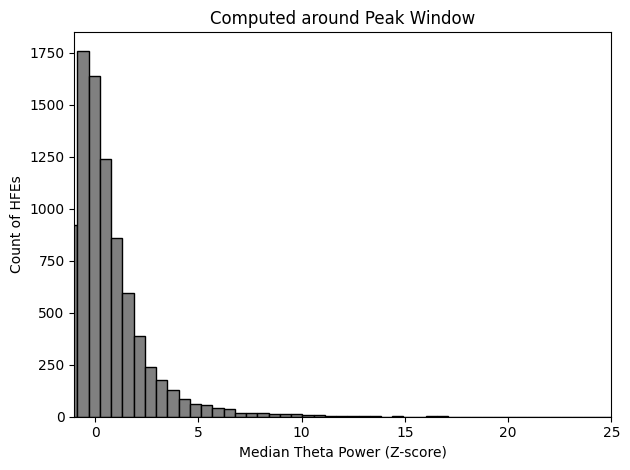

In [18]:
plt.hist(
    cleaned_theta_data["peakwindow_med"], bins=90, edgecolor="black", facecolor="grey"
)
plt.xlim(-1, 25)
plt.xlabel("Median Theta Power (Z-score)")
plt.ylabel("Count of HFEs")
plt.title("Computed around Peak Window")
plt.tight_layout()
plt.show()

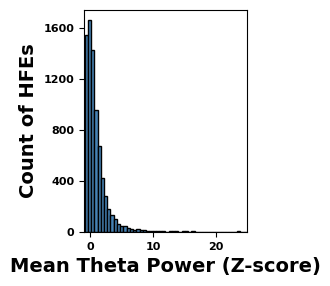

In [19]:
# Ensure text is exported as text objects
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams["pdf.use14corefonts"] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

plt.hist(
    cleaned_theta_data["peakwindow_mean"],
    bins=90,
    edgecolor="black",
    facecolor="steelblue",
)
plt.xlim(-1, 25)
plt.xlabel("Mean Theta Power (Z-score)", fontsize=14, weight="bold")
plt.ylabel("Count of HFEs", fontsize=14, weight="bold")
# plt.title('Computed around Peak Window')

# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))

plt.tight_layout()
plt.savefig(f"{figure_six_path}six_behave_a.svg", format="svg")
plt.show()

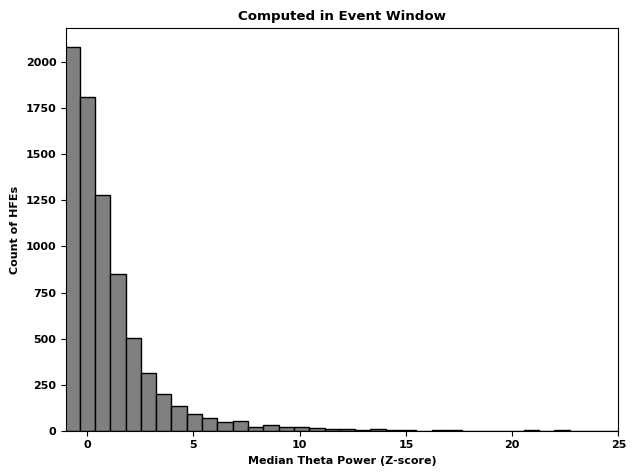

In [20]:
plt.hist(
    cleaned_theta_data["eventwindow_med"], bins=90, edgecolor="black", facecolor="grey"
)
plt.xlim(-1, 25)
plt.xlabel("Median Theta Power (Z-score)")
plt.ylabel("Count of HFEs")
plt.title("Computed in Event Window")
plt.tight_layout()
plt.show()

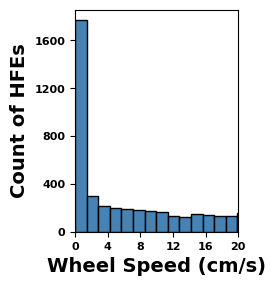

In [21]:
# Ensure text is exported as text objects
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams["pdf.use14corefonts"] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

plt.hist(speeds, bins=100, edgecolor="black", facecolor="steelblue")
# Ensure text is exported as text objects
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
plt.xlim(0, 20)
plt.xlabel("Wheel Speed (cm/s)", fontsize=14, weight="bold")
plt.ylabel("Count of HFEs", fontsize=14, weight="bold")

# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))


plt.tight_layout()
plt.savefig(f"{figure_six_path}six_behave_c.svg", format="svg")
plt.show()

## Ripple Distributions

In [22]:
# getting
directories = os.listdir(abi_ripples_path)

processed_sesh_ids = [
    dir.replace("swrs_session_", "") for dir in directories if "swrs_session_" in dir
]

print(processed_sesh_ids)

['1118327332', '1120251466', '1130113579', '1118512505', '1108335514', '1128520325', '1109680280', '1087720624', '1130349290', '1104058216', '1064644573', '1092283837', '1118324999', '1047977240', '1048196054', '1064400234', '1065449881', '1065908084', '1044385384', '1053709239', '1118508667', '1109889304', '1121406444', '1067781390', '1108528422', '1115077618', '1093864136', '1115356973', '1152811536', '1115368723', '1090800639', '1123100019', '1095138995', '1121607504', '1052533639', '1125937457', '1087992708', '1064415305', '1108531612', '1112302803', '1065437523', '1139846596', '1065905010', '1092466205', '1104297538', '1081079981', '1116941914', '1081429294', '1086200042', '1111013640', '1064639378', '1105543760', '1095340643', '1086410738', '1048189115', '1047969464', '1124507277', '1055221968', '1105798776', '1049273528', '1053718935', '1112515874', '1044594870', '1124285719', '1111216934', '1091039376', '1104052767', '1122903357', '1128719842', '1062755779', '1096620314', '1071

In [23]:
all_swrs_df = pd.DataFrame()
global_swr_failed_session = []
for sessionfolder in os.listdir(abi_ripples_path):
    try:
        if "global_swrs_no_movement_no_gamma.csv" in sessionfolder:
            continue
        folder_path = os.path.join(abi_ripples_path, sessionfolder)
        folderfiles = os.listdir(folder_path)
        try:
            global_ripples_filename = [
                file for file in folderfiles if "global_swrs" in file
            ][0]

        except:
            continue
        global_ripples_df = pd.read_csv(
            os.path.join(folder_path, global_ripples_filename), compression="gzip"
        )
        global_ripples_df["duration"] = (
            global_ripples_df["end_time"] - global_ripples_df["start_time"]
        )
        global_ripples_df["session_id"] = sessionfolder.replace("swrs_session_", "")
        all_swrs_df = pd.concat([all_swrs_df, global_ripples_df])
    except:
        global_swr_failed_session.append(sessionfolder)

In [24]:
all_swrs_df.columns

Index(['start_time', 'end_time', 'probes_event_is_on', 'events_row_index',
       'global_peak_time', 'global_max_zscore', 'peak_probe', 'duration',
       'session_id'],
      dtype='object')

In [25]:
all_swrs_df.shape

(1374811, 9)

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.000006,2668.073605,-3.605000e+07,inf,0.017353,0.0
halfnorm,0.000053,15234.203577,-3.297952e+07,inf,0.098578,0.0
norm,0.000146,29996.539912,-3.157226e+07,inf,0.150250,0.0


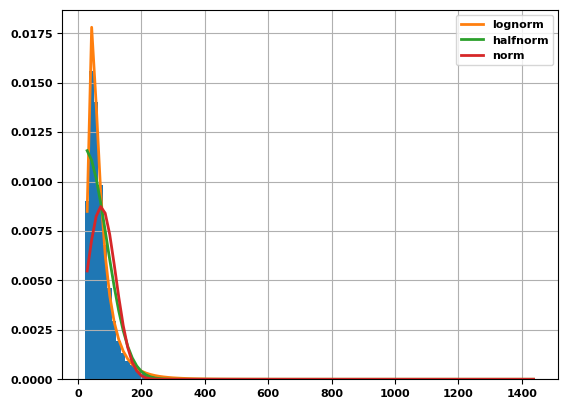

In [26]:
f_distributions_dur = Fitter(
    all_swrs_df["duration"] * 1000, distributions=["norm", "lognorm", "halfnorm"]
)
f_distributions_dur.fit()
f_distributions_dur.summary()

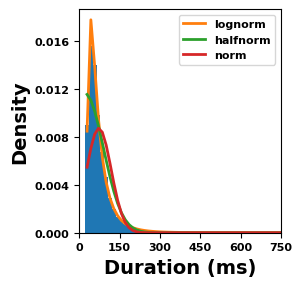

In [27]:
# Ensure text is exported as text objects
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams["pdf.use14corefonts"] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

# Plot the histogram
f_distributions_dur.hist()

# Plot the PDF
f_distributions_dur.plot_pdf()

# Get the current axes and turn off the grid
ax = plt.gca()
ax.grid(False)
ax.set_xlim(0, 750)

# Set the title and axis labels
ax.set_xlabel("Duration (ms)", fontsize=14, weight="bold")
ax.set_ylabel("Density", fontsize=14, weight="bold")

# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))

plt.savefig(f"{figure_six_path}six_behave_e.svg", format="svg")
# Display the plot
plt.show()

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
lognorm,0.001452,3785.315400,-2.841508e+07,inf,0.028275,0.0
halfnorm,0.029058,49839.390601,-2.429603e+07,inf,0.136352,0.0
norm,0.041003,103147.868304,-2.382261e+07,inf,0.169931,0.0


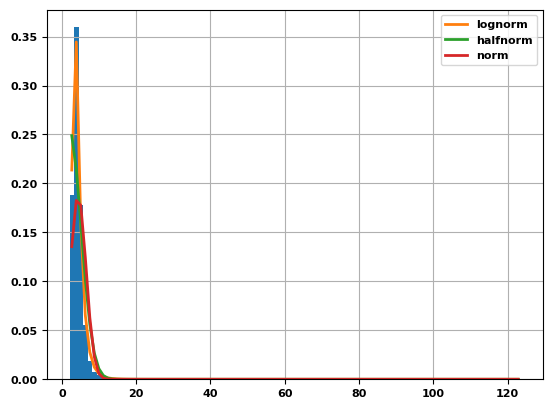

In [28]:
f_distributions_pow = Fitter(
    all_swrs_df["global_max_zscore"], distributions=["norm", "lognorm", "halfnorm"]
)
f_distributions_pow.fit()
f_distributions_pow.summary()

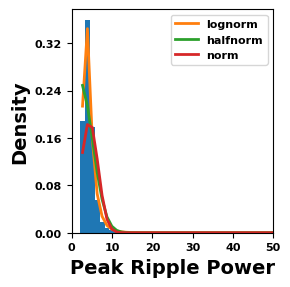

In [29]:
# Ensure text is exported as text objects
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["text.usetex"] = False  # Do not use LaTeX for rendering text
plt.rcParams["font.weight"] = "bold"
plt.rcParams["pdf.use14corefonts"] = False
plt.rcParams["font.size"] = 8
plt.rcParams["axes.titleweight"] = "bold"  # Make the title bold
plt.rcParams["axes.labelweight"] = "bold"

# set figzise in mm
width_mm = 66
height_mm = 73.75

# Set figure size in inches
plt.figure(figsize=(width_mm / 25.4, height_mm / 25.4))

# Plot the histogram
f_distributions_pow.hist()

# Plot the PDF
f_distributions_pow.plot_pdf()

# Get the current axes and turn off the grid
ax = plt.gca()
ax.grid(False)

# Set x-axis limits
# ax.set_xlim([0, 70])  # replace with your desired limits
# Reduce the number of y-ticks
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))


# Set the title and axis labels
ax.set_xlabel("Peak Ripple Power", fontsize=14, weight="bold")
ax.set_ylabel("Density", fontsize=14, weight="bold")
ax.set_xlim([0, 50])
plt.savefig(f"{figure_six_path}six_behave_g.svg", format="svg")
# Display the plot
plt.show()

## Plotting Probe Position in CA1

Using this code you can take snapshots of the probe locations in CA1.

In [30]:
seshes = os.listdir(
    "/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_murphylab2024"
)
seshes = [s.replace("swrs_session_", "") for s in seshes if "swrs_session_" in s]
seshes = [int(s) for s in seshes]
abi_ripples_path

'/space/scratch/allen_visbehave_swr_data/allen_visbehave_swr_murphylab2024'

This line may be needed to be fun in the conda env the first time you run this code, brainrender is not fully compatible with notebooks yet and reuires a bit of fiddling with the environment to get it to run in cells without throwing an error.

In [31]:
#!jupyter nbextension enable --py widgetsnbextension --sys-prefix

In [32]:
import random

import numpy as np

from brainrender import Scene
from brainrender.actors import Points
import vedo

vedo.settings.default_backend = "k3d"

from vedo import Plotter  # <- this will be used to render an embedded scene


# Display the Allen Brain mouse atlas.
scene = Scene(atlas_name="allen_mouse_25um", title="Inserts in CA1")
# Make sure it gets embedded in the window
scene.jupyter = True


def get_n_random_points_in_region(region, N):
    """
    Gets N random points inside (or on the surface) of a mes
    """

    region_bounds = region.mesh.bounds()
    X = np.random.randint(region_bounds[0], region_bounds[1], size=10000)
    Y = np.random.randint(region_bounds[2], region_bounds[3], size=10000)
    Z = np.random.randint(region_bounds[4], region_bounds[5], size=10000)
    pts = [[x, y, z] for x, y, z in zip(X, Y, Z)]

    ipts = region.mesh.inside_points(pts).coordinates
    return np.vstack(random.choices(ipts, k=N))


scene = Scene(title="Labelled cells")

# Display a brain region
cornu_Ammonis_1 = scene.add_brain_region("CA1", alpha=0.2)

ca1_coordinates = []

# Iterate over all subdirectories in the base directory
for dir_name in os.listdir(abi_ripples_path):
    if "swrs_session_" in dir_name:
        # Extract the session ID from the directory name and get the session data
        session_id = int(dir_name.split("swrs_session_")[1])
        session = cache.get_ecephys_session(ecephys_session_id=session_id)
        session.channels = session.get_channels()

        # Iterate over all files in the directory
        for file_name in os.listdir(os.path.join(abi_ripples_path, dir_name)):
            ca1_coordinates = []
            if "karlsson" in file_name:
                # Extract probe_id from the filename
                probe_id = int(re.search("probe_(.*?)_", file_name).group(1))

                # Get a list of all CA1 channel ids specific to the probe_id
                ca1index = session.channels[
                    (session.channels["structure_acronym"] == "CA1")
                    & (session.channels["probe_id"] == probe_id)
                ].index

                # Get the coordinates for all CA1 channels specific to the probe_id
                ca1_coordinates = session.channels.loc[
                    ca1index,
                    [
                        "anterior_posterior_ccf_coordinate",
                        "dorsal_ventral_ccf_coordinate",
                        "left_right_ccf_coordinate",
                    ],
                ].values.astype(np.float32)
                ca1_coordinates = ca1_coordinates.astype(np.float32)
                # Extract the dorsal_ventral_ccf_coordinate values
                dorsal_ventral_values = ca1_coordinates[:, 1]

                # Sort the values
                sorted_values = np.sort(dorsal_ventral_values)

                # Calculate the mid-point
                mid_point_value = sorted_values[len(sorted_values) // 2]

                # Find the row with the mid-point value
                mid_point_row = ca1_coordinates[
                    np.where(ca1_coordinates[:, 1] == mid_point_value)
                ]
                mid_point_row = mid_point_row.astype(np.float32)
                scene.add(
                    Points(
                        mid_point_row,
                        name="probe_1",
                        colors="black",
                        radius=100,
                    )
                )

# Add label to the brain region
scene.add_label(cornu_Ammonis_1, "CA1")

# render
scene.content
scene.render()

plt = Plotter()
plt.show(*scene.renderables)

/home/acampbell/miniconda3/envs/allensdk_env/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.8.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/acampbell/miniconda3/envs/allensdk_env/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/acampbell/miniconda3/envs/allensdk_env/lib/python3.10/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.5.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/acampbell/miniconda3/envs/allensdk_env/lib/python3.10/site-packages/hdmf/spec/namespace.py:5

Cannot run function add_label in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

╭─────────────────────────────────╮
│                                 │
│   Scene actors                  │
│   ────────────                  │
│                                 │
│   - root (type: brain region)   │
│   - title (type: title)         │
│   - CA1 (type: brain region)    │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: Points)      │
│   - probe_1 (type: [38;2

Cannot run function _get_inset in a jupyter notebook Try setting the correct backend before creating your scene:

from vedo import embedWindow                                                                                       
embedWindow(None)                                                                                                  

Your scene is ready for rendering, use:

from vedo import show                                                                                              
vedo.show(*scene.renderables)                                                                                      

/home/acampbell/miniconda3/envs/allensdk_env/lib/python3.10/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], backgro…